In [1]:
# Installing surprise library, only do it for first time
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-macosx_10_9_x86_64.whl size=1147567 sha256=b399fe1cb8dab01e3a8d6ca14292a2a31a32ebd6afd353e58b8af633e48e4bbe
  Stored in directory: /Users/hameed/Library/Caches/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [4]:
# Import the dataset
rating = pd.read_csv('ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])
rating = rating.drop('timestamp', axis=1) # Dropping timestamp

In [5]:
rating.head()

,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- There are **7824482 samples** and **4 features** in the data.

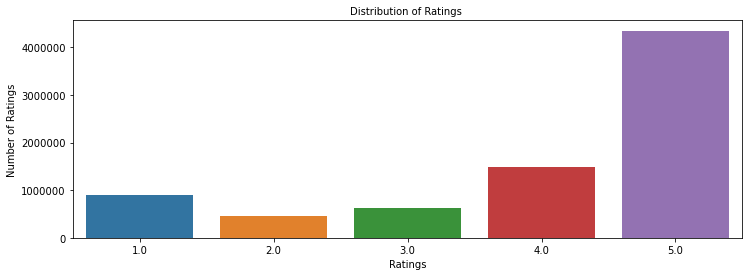

In [7]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

In [8]:
# Copying the data to another DataFrame
df=rating.copy()

In [9]:
# Get the column containing the users
users = rating.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [10]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.user_id.isin(remove_users)]

In [11]:
rating.shape

(125871, 3)

In [12]:
# Get the column containing the users
items = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for item in items:
    # If we already have the user, just add 1 to their rating count
    if item in ratings_count:
        ratings_count[item] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[item] = 1    

In [13]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_items = []
for item, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_items.append(item)
rating = rating.loc[~rating.item_id.isin(remove_items)]

In [14]:
rating.shape

(65290, 3)

In [15]:
# Finding number of unique users
rating['user_id'].nunique()

1540

In [16]:
# Finding number of unique items
rating['item_id'].nunique()

5689

In [17]:
rating.groupby(['user_id', 'item_id']).count()

rating
user_id        item_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [18]:
rating.groupby(['user_id', 'item_id']).count()['rating'].sum()

65290

In [19]:
rating['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: item_id, Length: 5689, dtype: int64

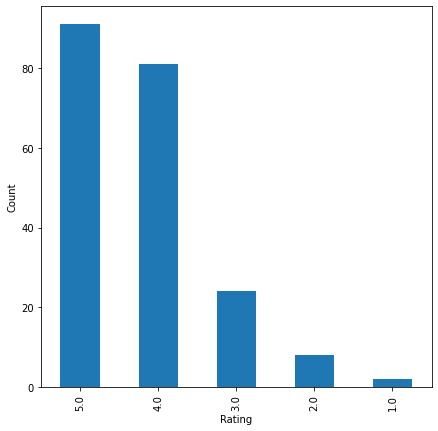

In [20]:
# Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [21]:
rating['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

In [22]:
# Finding user-item interactions distribution
count_interactions = rating.groupby('user_id').count()['item_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: item_id, Length: 1540, dtype: int64

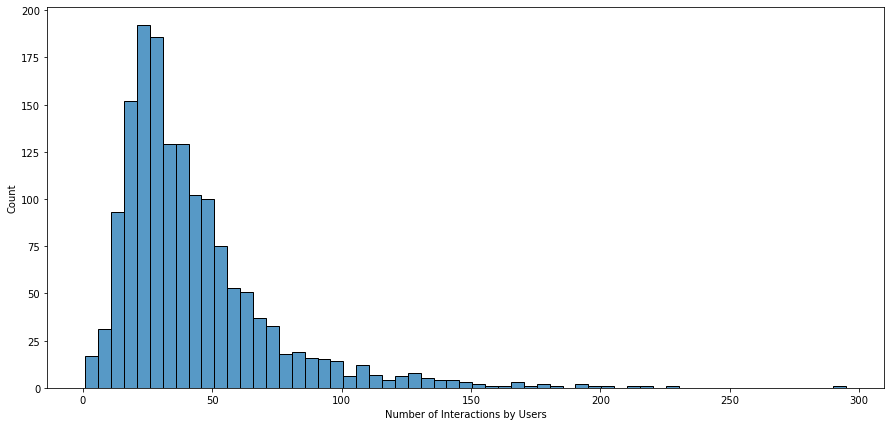

In [23]:
# Plotting user-item interactions distribution
plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

In [24]:
#Build rank-based recomendation 
# Calculating average ratings
average_rating = rating.groupby('item_id').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('item_id').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [25]:
final_rating.head()

,avg_rating,rating_count
item_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


Now, let's create a function to find the **top n items** for a recommendation based on the average ratings of items. We can also add a **threshold for a minimum number of interactions** for a item to be considered for recommendation. 

In [26]:
def top_n_items(data, n, min_interaction=30):
    
    # Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    # Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get items to be recommended.

In [27]:
list(top_n_items(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

In [28]:
from sklearn.preprocessing import LabelEncoder
df=rating[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=rating['rating']
df.head()

,user_id,item_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


In [29]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

In [30]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0552


1.0551559636074466

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` as shown below

In [31]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, as shown below - 

In [32]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

- As we can see the estimated rating for this user-item pair is 4.0 based on this similarity based baseline model

### Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and finding the RMSE for tuned user based collaborative filtering recommendation system**

In [33]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9722330525400468
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [34]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.974952,0.981926,0.976371,0.977750,0.003010,14,0.726377,0.728637,0.726267,0.727094,0.001092,1,0.318222,0.033872,2.698261,0.041520,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.972192,0.976774,0.971824,0.973597,0.002252,9,0.729109,0.729725,0.727707,0.728847,0.000845,6,1.132563,0.467344,1.730947,0.253615,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.971853,0.975667,0.970729,0.972750,0.002113,6,0.747239,0.747990,0.745797,0.747008,0.000910,7,0.308379,0.169595,1.668794,0.408018,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.972553,0.975033,0.970114,0.972567,0.002008,4,0.750264,0.750063,0.747665,0.749331,0.001181,12,0.176592,0.017286,1.980208,0.153878,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.976511,0.979507,0.977421,0.977813,0.001254,15,0.759992,0.760486,0.759364,0.759948,0.000459,13,0.165630,0.009955,1.886262,0.172677,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [35]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887


0.988698949219415

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [36]:
similarity_algo_optimized_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, by using the optimized model as shown below - 

In [37]:
similarity_algo_optimized_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=0` based on the `msd` distance metric

In [38]:
similarity_algo_optimized_user.get_neighbors(0, k=5)

[7, 12, 14, 23, 47]

In [39]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returing top n highest predicted rating items for this user

#### **Predicted top 5 items for userId=4 with similarity based recommendation system**

In [40]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_user)

In [41]:
recommendations

[(850, 5),
 (2857, 4.875),
 (2277, 4.856530910239044),
 (2722, 4.833333333333333),
 (4189, 4.833053684165744)]

In [42]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0697


1.0697030922594737

In [43]:
algo_knn_item.predict(0, 3096, r_ui=4, verbose=True)

user: 0          item: 3096       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3096, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model

Let's predict  the rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=22607`

In [44]:
algo_knn_item.predict(0, 22607, verbose=True)

user: 0          item: 22607      r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=0, iid=22607, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

### Performing hyperparameter tuning for the baseline item based collaborative filtering recommendation system and finding the RMSE for tuned item based collaborative filtering recommendation system**

In [45]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [46]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.990052,0.980600,0.986987,0.985880,0.003937,16,0.730214,0.722211,0.727583,0.726669,0.003330,1,0.743191,0.044009,1.557839,0.518311,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,0.989100,0.982118,0.987314,0.986177,0.002961,18,0.736514,0.730128,0.733809,0.733484,0.002617,6,1.867900,0.282621,1.689392,0.489359,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.979005,0.969323,0.978370,0.975566,0.004422,5,0.743576,0.737890,0.744561,0.742009,0.002940,7,0.925933,0.180795,1.965073,1.095023,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,0.981174,0.972515,0.980371,0.978020,0.003906,11,0.750242,0.744674,0.750092,0.748336,0.002590,12,1.642389,0.438768,1.735704,0.325658,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.978323,0.970088,0.977585,0.975332,0.003720,2,0.754525,0.749113,0.754694,0.752777,0.002592,13,2.351490,1.258355,4.879891,2.883218,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [47]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9896


0.9895877571156905

- We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.06. We can say that we have been able to improve the model after hyperparameter tuning.

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [48]:
similarity_algo_optimized_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})


- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.29` and the optimized model predicted the rating as `4.29`. whereas the actual rating is `4.0`.

Let's predict the rating for the same `userId=0` but for a item which this user has not interacted before i.e. `itemId=100`, by using the optimized model:

In [49]:
similarity_algo_optimized_item.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})


- If we compare the above predicted rating, we can see the baseline model predicted rating as `5` and the optimized model predicted the rating as `4.29`.


We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar item to the `itemId=100` based on the `msd` distance metric

In [50]:
similarity_algo_optimized_item.get_neighbors(100, k=5)

[13, 25, 44, 67, 72]

**Predicted top 5 items for userId=4 with similarity based recommendation system**

In [51]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_item)

In [52]:
recommendations

[(5155, 4.846153846153846),
 (1997, 4.701088473346358),
 (3975, 4.692622950819672),
 (4253, 4.612068965517241),
 (5489, 4.536817102137767)]

#### **Building a baseline matrix factorization recommendation system**

In [53]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9298


0.9297835488422698



- We can that the baseline RMSE for matrix factorization model on testset (which is `0.93`) is lower as compared to the RMSE for baseline similarity based recommendation system (which is `1.06`) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is `0.99`)

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` as shown below

In [54]:
algo_svd.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.74   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.739693707144238, details={'was_impossible': False})



- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.71 by this matrix factorization based baseline model. It seems like we have over estimated the rating by a small margin. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV

Below we are predicting rating for the same `userId=0` but for a item which this user has not interacted before i.e. `userId=100`, as shown below - 

In [55]:
algo_svd.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.46   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.460976397477576, details={'was_impossible': False})

In [56]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8979478487963467
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [57]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.956874,0.955346,0.949173,0.953798,0.003329,25,0.738431,0.738478,0.734877,0.737262,0.001687,25,0.503407,0.010440,0.388006,0.006513,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.957350,0.955619,0.949109,0.954026,0.003548,27,0.740034,0.740611,0.736325,0.738990,0.001899,26,0.516364,0.007450,0.394681,0.014982,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.956185,0.956603,0.949110,0.953966,0.003438,26,0.740570,0.742503,0.736580,0.739884,0.002466,27,0.494777,0.013315,0.422365,0.016763,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.916766,0.914951,0.905976,0.912565,0.004717,16,0.686359,0.686660,0.681106,0.684708,0.002550,16,0.534893,0.014932,0.419230,0.010841,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.917297,0.915737,0.907500,0.913511,0.004298,17,0.690821,0.691057,0.685912,0.689263,0.002371,17,0.519064,0.007647,0.435660,0.010625,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [58]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9232


0.9231696499098728

Let's us now predict rating for an user with `userId=0` and for `itemId=3906` with the optimized model as shown below

In [59]:
svd_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.66   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.6630097844738465, details={'was_impossible': False})



- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.71` and the optimized model predicted the rating as `4.86`. whereas the actual rating is `4`.

In [60]:
svd_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.61   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.605171028133748, details={'was_impossible': False})

In [61]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(1309, 5),
 (4638, 5),
 (5194, 4.9943585913704736),
 (5172, 4.951389525123321),
 (4886, 4.951227381278682)]

Below we are comparing the rating predictions of users for those items which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [62]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['itemId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=4`

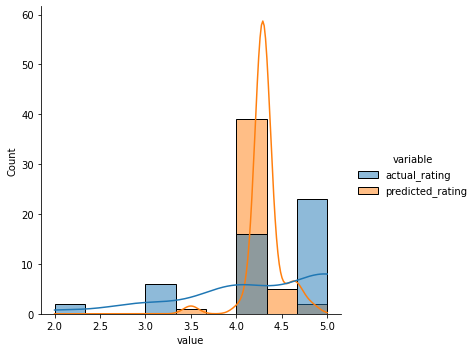

In [63]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, similarity_algo_optimized_user)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);



- We can see that distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.
- We are getting more predicted values in between 4 and 5,this is expected, as actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given user. But over the predictions looks good as compared to the distribution of actual ratings.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=4`

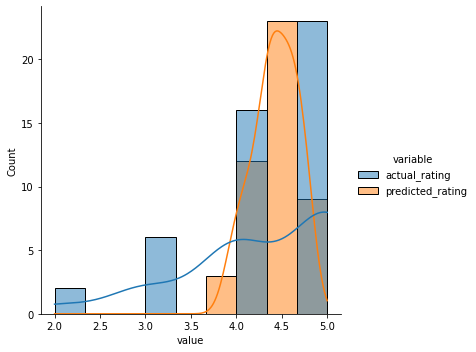

In [64]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

In [65]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [66]:
#Computing the precision and recall
from collections import defaultdict

# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [67]:
# Make list of k values
# A basic cross-validation iterator.
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]


for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.869
-----> Recall:  0.688
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.859
-----> Recall:  0.702
> k=5, model=KNNBasic
-----> Precision:  0.836
-----> Recall:  0.658
> k=5, model=KNNBasic
-----> Precision:  0.843
-----> Recall:  0.69
> k=5, model=SVD
-----> Precision:  0.867
-----> Recall:  0.692
> k=5, model=SVD
-----> Precision:  0.872
-----> Recall:  0.698
> k=10, model=KNNBasic
-----> Precision:  0.852
-----> Recall:  0.86
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done co


* Collaborative Filtering using user-user based interaction performed well in both the k values with Precision value ~84% (k=10) and with k=5, ~86%.

* Tuned SVD has better RMSE than all models but Collaborative Filtering using user-user based interaction is also giving good results based on Precsion and recall @k for K=10. 

* The final model will denpend on the business requirements as whether they have to minimize RMSE or go with maximizing Precision/Recall. 



- User-based and Item-based Collaborative Models have nearly same. User based RMSE values (1.05) while the "Item based" model's RMSE is 1.06. Clearly, tuned Collaborative Filtering Models have performed better than baseline model and the user-user based tuned model is performing better and have  rmse of 0.9887

- The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

- Collaborative Filtering searches for neighbors based on similarity of item (example) preferences and recommend items that those neighbors interacted while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- RMSE for Matrix Factorization (0.92) is better than the Collaborative Filtering Models (~1.00).
- Tuning SVD matrix factorization model is not improving the base line SVD much.  
- Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend a item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

### **Conclusions**

We build 3 recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering